In [23]:
# Python 3
%autoreload
import jpeg as JPEG
import libs.ruidos as ruido
import libs.metricas as metricas
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fftpack
from scipy.ndimage import filters


In [24]:
def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# No usar bloques
La idea es ver que no está bueno aplicar la DCT a la imagen completa

In [ ]:
# img = np.transpose(io.imread('bmp/homogenea.bmp'))
img = io.imread('bmp/no_homogenea.bmp')
img_dct = get_2D_dct(img)
io.imsave('latex/fig/no_homogenea.png',img)

# máscara
menores_coef_mask = np.flip(np.tril(np.ones(img.shape),0),0)

img_dct_trimmed = np.multiply(img_dct,menores_coef_mask)
# recorto coeficientes
img2 = get_2d_idct(img_dct_trimmed).clip(0,255).astype('uint8')

# muestro
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(img_dct,cmap='gray')
plt.title('DCT')

plt.subplot(1,4,2)
plt.imshow(menores_coef_mask,cmap='gray')
plt.title('mask')

plt.subplot(1,4,3)
plt.imshow(img_dct_trimmed,cmap='gray')
plt.title('DCT - recortada')

plt.subplot(1,4,4)
plt.imshow(img2,cmap='gray')
plt.title('comprimida')

plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img2,cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img,cmap='gray')
plt.show()

io.imsave('latex/fig/no_homogenea_comprimida.png',img2)

# Las frecuencias bajas tienen más información
La idea es ver que las frecuencias bajas tienen más información que las altas, para el ojo humano.

In [ ]:

img = io.imread('bmp/lena.bmp')[:,:,0]
dct_size = img.shape[0]
dct = get_2D_dct(img)
reconstructed_images = []

for ii in range(dct_size):
    dct_copy = dct.copy()
    
    dct_copy[ii:,:] = 0
    dct_copy[:,ii:] = 0

    # Reconstructed image
    reconstructed_image = get_2d_idct(dct_copy)

    # Create a list of images
    reconstructed_images.append(reconstructed_image)

In [ ]:
fig = plt.figure(figsize=(10,7))
for ii in range(40):
    plt.subplot(5,8, ii+1)
    plt.imshow(reconstructed_images[ii], cmap='gray')
    plt.axis('off')
#     plt.tight_layout()
plt.savefig('latex/fig/lenas.png',bbox_inches='tight')
plt.show()

io.imsave('latex/fig/lenas_100frecuencias.png',np.array(reconstructed_images[100].clip(0,255),dtype=np.uint8))

Ahora veamos cómo se reconstruye Lena con las primeras 100 frecuencias nada más. Se ve, pero tiene artifacts groseros.

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(reconstructed_images[100],cmap='gray')
plt.show()

# Señal y su DCT
La idea es poner un ejemplo de DCT, y notar que cuando la imagen es suave la DCT concentra energía.

In [ ]:
# 8x8 random y su DCT
img = np.array(np.random.rand(8,8)*255,dtype=np.int)
img = filters.gaussian_filter(img, 1.2) -128

dct = get_2D_dct(img)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img,cmap='gray')
for (j,i),label in np.ndenumerate(img):
    ax.text(i,j,label,ha='center',va='center',fontsize=25,color='r')
ax.tick_params(labelsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('latex/fig/8x8random.png')
plt.show()
    
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(dct,cmap='gray')
for (j,i),label in np.ndenumerate(dct):
    ax.text(i,j,"{0:.1f}".format(label),ha='center',va='center',fontsize=25,color='r')
ax.tick_params(labelsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('latex/fig/8x8random_dct.png')
plt.show()

Ahora mostrar que cuando no es suave, la DCT no concentra energía.

In [ ]:
# distintos 8x8 y sus dct
sigmas = [0.1,1,2,5]

n = 0
for sigma in sigmas:

    img = np.array(np.random.rand(8,8)*255,dtype=np.int)
    img = filters.gaussian_filter(img, sigma) -128
    dct = get_2D_dct(img)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    for (j,i),label in np.ndenumerate(img):
        ax.text(i,j,label,ha='center',va='center',fontsize=25,color='r')
    ax.tick_params(labelsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('latex/fig/8x8random'+str(n)+'.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(dct,cmap='gray')
    for (j,i),label in np.ndenumerate(dct):
        ax.text(i,j,"{0:.1f}".format(label),ha='center',va='center',fontsize=25,color='r')
    ax.tick_params(labelsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('latex/fig/8x8random_dct'+str(n)+'.png')
    plt.show()
    n += 1


# Compresión y calidad
La idea es ver cómo cambia la calidad de la imagen con más compresión

In [28]:
def JPEG_compress(img, Q, NM = (8,8), QTable = np.array([\
        [16,11,10,16,24,40,51,61],\
        [12,12,14,19,26,58,60,55],\
        [14,13,16,24,40,57,69,56],\
        [14,17,22,29,51,87,80,62],\
        [18,22,37,56,68,109,103,77],\
        [24,35,55,64,81,104,113,92],\
        [49,64,78,87,103,121,120,101],\
        [72,92,95,98,112,100,103,99],\
        ])):
    
    jpeg = JPEG.jpeg_encode(img,Q, NM, QTable)
    bytes = jpeg.size()
    img2 = JPEG.jpeg_decode(jpeg)
    return (img2, bytes)

In [35]:
%autoreload
def comprimir_y_medir(img,QQ):
    sizes = []
    imgs = []
    for Q in QQ:
        print('Comprimiendo con Q =',Q)
        (img2,size) = JPEG_compress(img, Q)
        sizes.append(size)
        imgs.append(img2)
    return (imgs, sizes)

In [38]:
QQ = np.arange(50,102,2)

lena = io.imread('bmp/lena.bmp')
(lenas, lenas_sizes) = comprimir_y_medir(lena, QQ)

paisaje = io.imread('bmp/landscape.jpg')
(paisajes, paisajes_sizes) = comprimir_y_medir(paisaje, QQ)

txt = io.imread('bmp/text.bmp')
(txts, txt_sizes) = comprimir_y_medir(txt, QQ)

Comprimiendo con Q = 50
Comprimiendo con Q = 52
Comprimiendo con Q = 54
Comprimiendo con Q = 56
Comprimiendo con Q = 58
Comprimiendo con Q = 60
Comprimiendo con Q = 62
Comprimiendo con Q = 64
Comprimiendo con Q = 66
Comprimiendo con Q = 68
Comprimiendo con Q = 70
Comprimiendo con Q = 72
Comprimiendo con Q = 74
Comprimiendo con Q = 76
Comprimiendo con Q = 78
Comprimiendo con Q = 80
Comprimiendo con Q = 82
Comprimiendo con Q = 84
Comprimiendo con Q = 86
Comprimiendo con Q = 88
Comprimiendo con Q = 90
Comprimiendo con Q = 92
Comprimiendo con Q = 94
Comprimiendo con Q = 96
Comprimiendo con Q = 98
Comprimiendo con Q = 100


/home/nicolas/Documents/IPDI/jpeg/jpeg.py:278: RuntimeWarning: overflow encountered in byte_scalars
  img_blocks_dctq[i][0][0] = img_blocks_dctq[i-1][0][0] + img_blocks_dctq[i][0][0]


Comprimiendo con Q = 50
Comprimiendo con Q = 52
Comprimiendo con Q = 54
Comprimiendo con Q = 56
Comprimiendo con Q = 58
Comprimiendo con Q = 60
Comprimiendo con Q = 62
Comprimiendo con Q = 64
Comprimiendo con Q = 66
Comprimiendo con Q = 68
Comprimiendo con Q = 70
Comprimiendo con Q = 72
Comprimiendo con Q = 74
Comprimiendo con Q = 76
Comprimiendo con Q = 78
Comprimiendo con Q = 80
Comprimiendo con Q = 82
Comprimiendo con Q = 84
Comprimiendo con Q = 86
Comprimiendo con Q = 88
Comprimiendo con Q = 90
Comprimiendo con Q = 92
Comprimiendo con Q = 94
Comprimiendo con Q = 96
Comprimiendo con Q = 98
Comprimiendo con Q = 100
Comprimiendo con Q = 50
Comprimiendo con Q = 52
Comprimiendo con Q = 54
Comprimiendo con Q = 56
Comprimiendo con Q = 58
Comprimiendo con Q = 60
Comprimiendo con Q = 62
Comprimiendo con Q = 64
Comprimiendo con Q = 66
Comprimiendo con Q = 68
Comprimiendo con Q = 70
Comprimiendo con Q = 72
Comprimiendo con Q = 74
Comprimiendo con Q = 76
Comprimiendo con Q = 78
Comprimiendo co

In [44]:
lena_size = lena.shape[0] * lena.shape[1]* lena.shape[2]
paisaje_size = paisaje.shape[0] * paisaje.shape[1]* paisaje.shape[2]
txt_size = txt.shape[0] * txt.shape[1]* txt.shape[2]

PSNR_lenas = [metricas.PSNR(lena, img2) for img2 in lenas]
MSE_lenas = [metricas.MSE(lena, img2) for img2 in lenas]
FC_lenas = [metricas.FC(lena_size, size) for size in lenas_sizes]

PSNR_paisajes = [metricas.PSNR(paisaje, img2) for img2 in paisajes]
MSE_paisajes = [metricas.MSE(paisaje, img2) for img2 in paisajes]
FC_paisajes = [metricas.FC(paisaje_size, size) for size in paisajes_sizes]

PSNR_txts = [metricas.PSNR(txt, img2) for img2 in txts]
MSE_txts = [metricas.MSE(txt, img2) for img2 in txts]
FC_txts = [metricas.FC(txt_size, size) for size in txt_sizes]


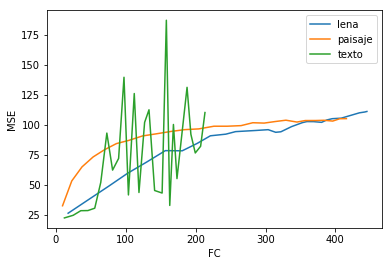

In [50]:
np.save('muchasdata.dat',(PSNR_lenas, MSE_lenas, FC_lenas, PSNR_paisajes, MSE_paisajes,FC_paisajes, PSNR_txts, MSE_txts, FC_txts))

# plt.figure(figsize=(30,30))
# for i in range(len(QQ)):
#     plt.subplot(1,len(QQ),i+1)
#     plt.imshow(imgs[i])
#     plt.title(sizes[i],fontsize=30)
# plt.show()


plt.plot(FC_lenas, MSE_lenas,label='lena')
plt.plot(FC_paisajes, MSE_paisajes,label='paisaje')
plt.plot(FC_txts, MSE_txts, label='texto')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('FC')
plt.show()

